# Imports


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from IPython.display import display, display_markdown
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)
from sklearn.model_selection import train_test_split

SEED = 0

# Load dataset

In [2]:
diab = pd.read_csv("../diabetes_prediction_dataset.csv")
display(diab.head())

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# DataCleaning

In [3]:
# Make a dataframe to count the null, na, and negative values
invalid_values = pd.DataFrame()
for col in diab.columns:
    if diab[col].dtype in ["int64", "float64"]:
        invalid_values[col] = [
            diab[col].isnull().sum(),
            diab[col].isna().sum(),
            (diab[col] < 0).sum(),
        ]
    else:
        invalid_values[col] = [diab[col].isnull().sum(), diab[col].isna().sum(), np.NaN]
invalid_values.index = ["Null count", "NaN count", "Negative count"]

display(invalid_values)
print("There are no null, NaN, or negative values in the dataset that need cleaning.\n")

print(f"Duplicated Rows: {diab.duplicated().sum()}")
# There are 3854 duplicate rows, let's drop them
diab_clean = diab.drop_duplicates().copy(True)

diab_clean["smoking_history_num"] = diab_clean["smoking_history"].map(
    {
        "No Info": 0,
        "never": 1,
        "ever": 2,
        "former": 3,
        "not current": 4,
        "current": 5,
    }
)

diab_clean["gender_num"] = diab_clean["gender"].map(
    {
        "Male": 0,
        "Female": 1,
        "Other": 2,
    }
)

print(f"There are {len(diab_clean)} clean rows left after dropping duplicates.")

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
Null count,0.0,0,0,0,0.0,0,0,0,0
NaN count,0.0,0,0,0,0.0,0,0,0,0
Negative count,NaN,0,0,0,NaN,0,0,0,0


There are no null, NaN, or negative values in the dataset that need cleaning.

Duplicated Rows: 3854
There are 96146 clean rows left after dropping duplicates.


## Preprocess data into numerical and categorical features

In [4]:
categorical_columns = set(
    ["diabetes", "heart_disease", "hypertension", "gender", "smoking_history"]
)
df_quantitative_columns = set(diab_clean.columns).difference(set(categorical_columns))
df_quantitative_columns = df_quantitative_columns.difference(
    {"smoking_history_num", "gender_num"}
)
df_quantitative = diab_clean[list(df_quantitative_columns)]
df_categorical = diab_clean[list(categorical_columns)]
display("quantitative columns: ", df_quantitative_columns)
display("categorial columns:", categorical_columns)

'quantitative columns: '

{'HbA1c_level', 'age', 'blood_glucose_level', 'bmi'}

'categorial columns:'

{'diabetes', 'gender', 'heart_disease', 'hypertension', 'smoking_history'}

## Perform exploratory data analysis

### Descriptive statistics

In [5]:
# Creating a dictionary to store the labeled dataframes
categorical_summary_dfs = {
    col: pd.concat(
        [
            df_categorical[col].value_counts(normalize=True),
            df_categorical[col].value_counts(),
        ],
        axis=1,
        keys=["proportion", "count"],
    )
    for col in df_categorical
}

# Concatenating along axis=0 with keys as column labels
categorical_summary_df = pd.concat(categorical_summary_dfs, axis=0)

# Displaying the dataframe
display(categorical_summary_df)

proportion  count
smoking_history never          0.357768  34398
                No Info        0.342053  32887
                former         0.096717   9299
                current        0.095657   9197
                not current    0.066222   6367
                ever           0.041583   3998
hypertension    0              0.922399  88685
                1              0.077601   7461
gender          Female         0.584122  56161
                Male           0.415691  39967
                Other          0.000187     18
diabetes        0              0.911780  87664
                1              0.088220   8482
heart_disease   0              0.959197  92223
                1              0.040803   3923

In [6]:
display_markdown(
    f"""This dataset contains {len(diab_clean)} rows and {len(diab_clean.columns)} columns.

The majority of subjects in this dataset are non-diabetic.  
{categorical_summary_df['count']['diabetes'][0]} non-diabetic subjects  
{categorical_summary_df['count']['diabetes'][1]} diabetic subjects  
{categorical_summary_df['proportion']['diabetes'][1] * 100:.2f}% diabetic proportion  

{categorical_summary_df['proportion']['hypertension'][1] * 100:.2f}% of subjects have hypertension  
{categorical_summary_df['proportion']['heart_disease'][1] * 100:.2f}% of subjects have heart disease  

This sample has a balanced number of male and female subjects. {categorical_summary_df['proportion']['gender']['Male'] * 100:.2f}% of subjects are male.""",
    raw=True,
)

This dataset contains 96146 rows and 11 columns.

The majority of subjects in this dataset are non-diabetic.  
87664 non-diabetic subjects  
8482 diabetic subjects  
8.82% diabetic proportion  

7.76% of subjects have hypertension  
4.08% of subjects have heart disease  

This sample has a balanced number of male and female subjects. 41.57% of subjects are male.

#### 5-number summary of dataset's quantitative features

In [7]:
df_summary = df_quantitative.describe()
df_summary.drop(labels=["count"], inplace=True)
display(df_summary)

,bmi,HbA1c_level,blood_glucose_level,age
mean,27.321461,5.532609,138.218231,41.794326
std,6.767716,1.073232,40.909771,22.462948
min,10.010000,3.500000,80.000000,0.080000
25%,23.400000,4.800000,100.000000,24.000000
50%,27.320000,5.800000,140.000000,43.000000
75%,29.860000,6.200000,159.000000,59.000000
max,95.690000,9.000000,300.000000,80.000000


HbA1c Level: The average is 5.53, with a standard deviation of 1.07. The range spans from 3.5 to 9.0, showing substantial variability.  

BMI: The mean BMI is 27.32, with a large standard deviation of 6.77. The minimum is 10.01 and the maximum is 95.69, suggesting a large number of outliers.  

Age: With a mean of 41.79 and a standard deviation of 22.46, this sample has a lot of age diversity. The youngest subject is 0.08 years old, and the oldest is 80 years. Little or no outliers are expected in this feature.  

Blood Glucose Level: The mean level is 138.22, with a standard deviation of 40.91. The minimum is 80 and the maximum is 300. Values over 160 are considered hyperglycemic.

#### 5-number summary of non-diabetic quantitative features

In [8]:
df_nondiabetic_summary = diab_clean[diab_clean["diabetes"] == 0][
    list(df_quantitative_columns)
].describe()
display(df_nondiabetic_summary)

,bmi,HbA1c_level,blood_glucose_level,age
count,87664.000000,87664.000000,87664.000000,87664.000000
mean,26.869003,5.396936,132.818489,39.943229
std,6.509884,0.970833,34.241382,22.228281
min,10.010000,3.500000,80.000000,0.080000
25%,23.000000,4.800000,100.000000,22.000000
50%,27.320000,5.800000,140.000000,40.000000
75%,29.180000,6.200000,158.000000,57.000000
max,95.690000,6.600000,200.000000,80.000000


#### 5-number summary of diabetic quantitative features

In [9]:
df_diabetic_summary = diab_clean[diab_clean["diabetes"] == 1][
    list(df_quantitative_columns)
].describe()
display(df_diabetic_summary)

,bmi,HbA1c_level,blood_glucose_level,age
count,8482.000000,8482.000000,8482.000000,8482.000000
mean,31.997755,6.934827,194.026173,60.925961
std,7.563494,1.076462,58.630047,14.545301
min,10.980000,5.700000,126.000000,3.000000
25%,27.320000,6.100000,145.000000,52.000000
50%,29.985000,6.600000,160.000000,62.000000
75%,35.940000,7.500000,240.000000,72.000000
max,88.720000,9.000000,300.000000,80.000000


All sample statistics of HbA1c for diabetic subjects is are higher than non-diabetic subjects. This may indicate that diabetic subjects have higher HbA1c levels on average.

Similarly, all sample statistics for blood glucose levels are higher for diabetic subjects than non-diabetic subjects, suggesting that diabetic subjects have higher blood glucose levels on average. 50% of diabetic subjects have blood glucose levels over 160, which is considered hyperglycemic, while fewer than 75% of non-diabetic subjects have blood glucose levels over 160.

Nearly all statistics, with the exception of the maximum, are higher for bmi in diabetic subjects compared to non-diabetic subjects. This suggests that diabetic subjects tend to have higher BMI values on average.

The average age of diabetic subjects is higher than non-diabetic subjects, and the standard deviation is smaller, indicating that subjects with diabetes may be older and closer in age than non-diabetic subjects.

In [10]:
print(
    f"""The dataset contains {len(diab_clean)} rows and {len(diab_clean.columns)} columns.

The quantitative columns are: {list(df_quantitative_columns)}.

The dataset has 
"""
)

The dataset contains 96146 rows and 11 columns.

The quantitative columns are: ['bmi', 'HbA1c_level', 'blood_glucose_level', 'age'].

The dataset has 



### Discriptive statistics visualizations

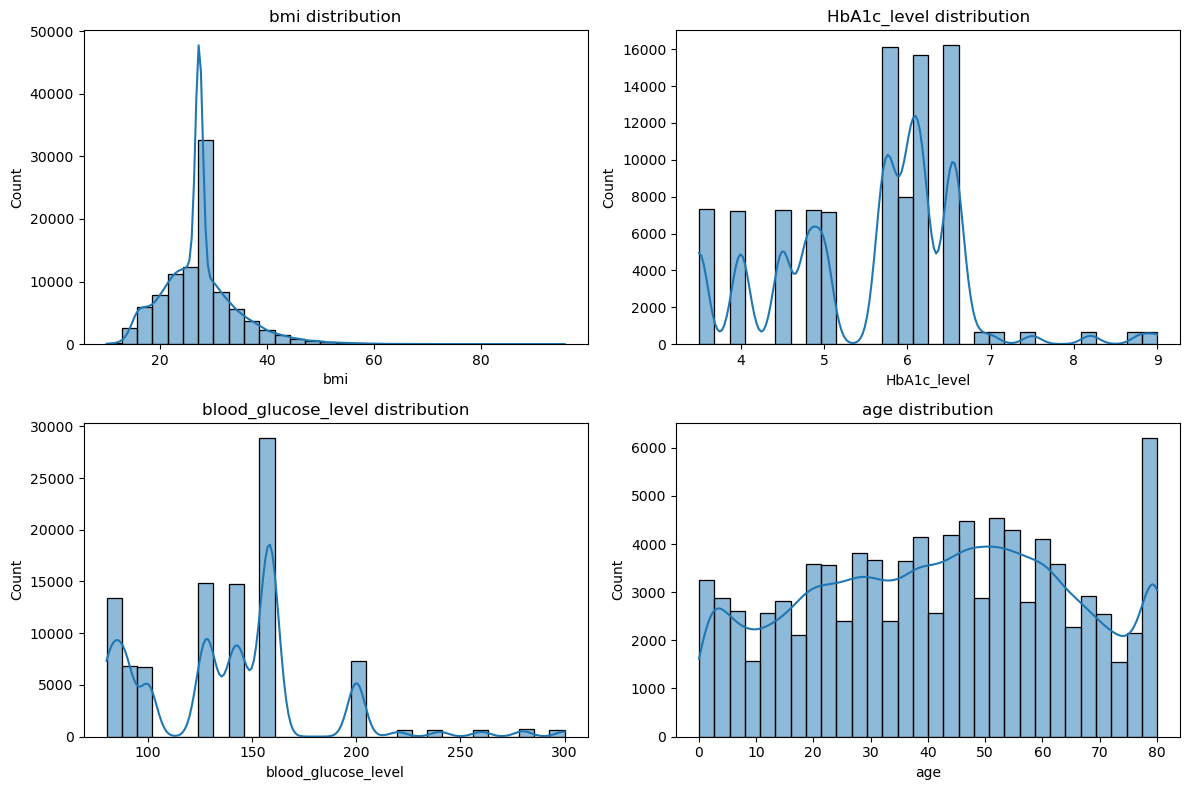

In [11]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(df_quantitative_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_quantitative[col], kde=True, bins=30)
    plt.title(f"{col} distribution")
plt.tight_layout()
plt.show()

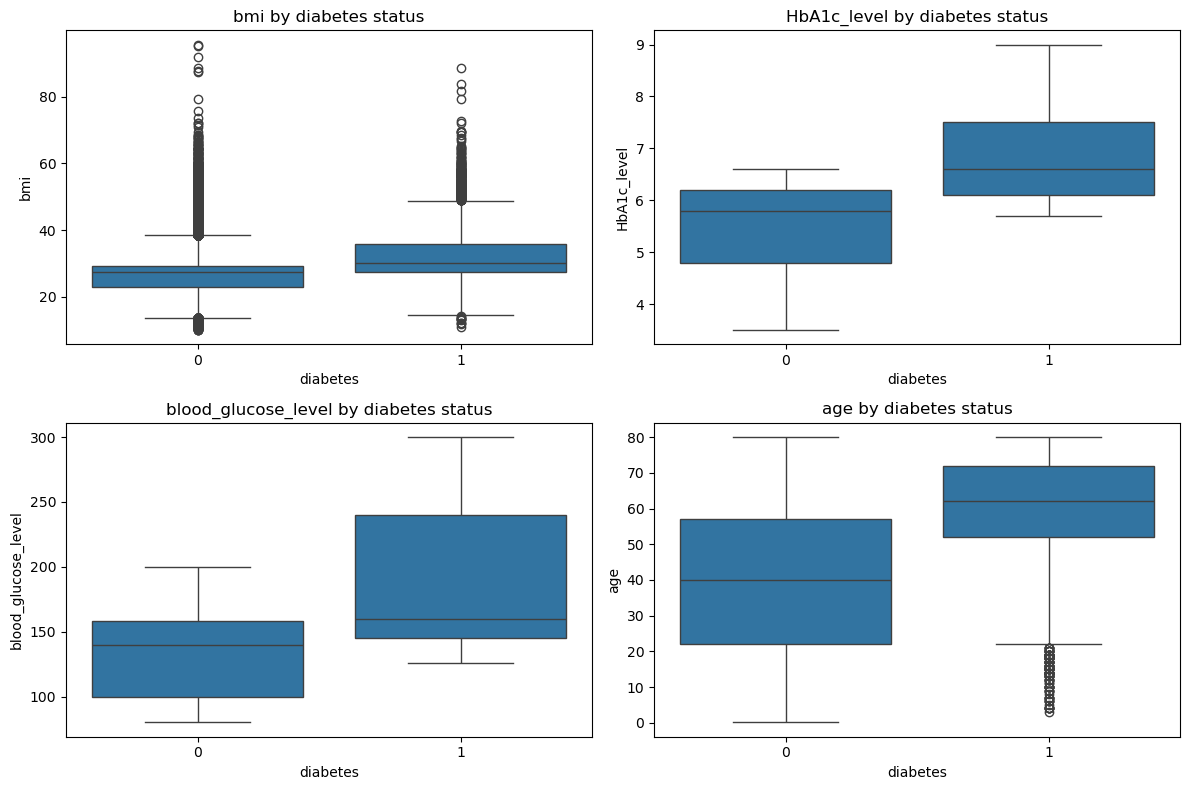

In [12]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(df_quantitative_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=diab_clean["diabetes"], y=diab_clean[col])
    plt.title(f"{col} by diabetes status")
plt.tight_layout()
plt.show()

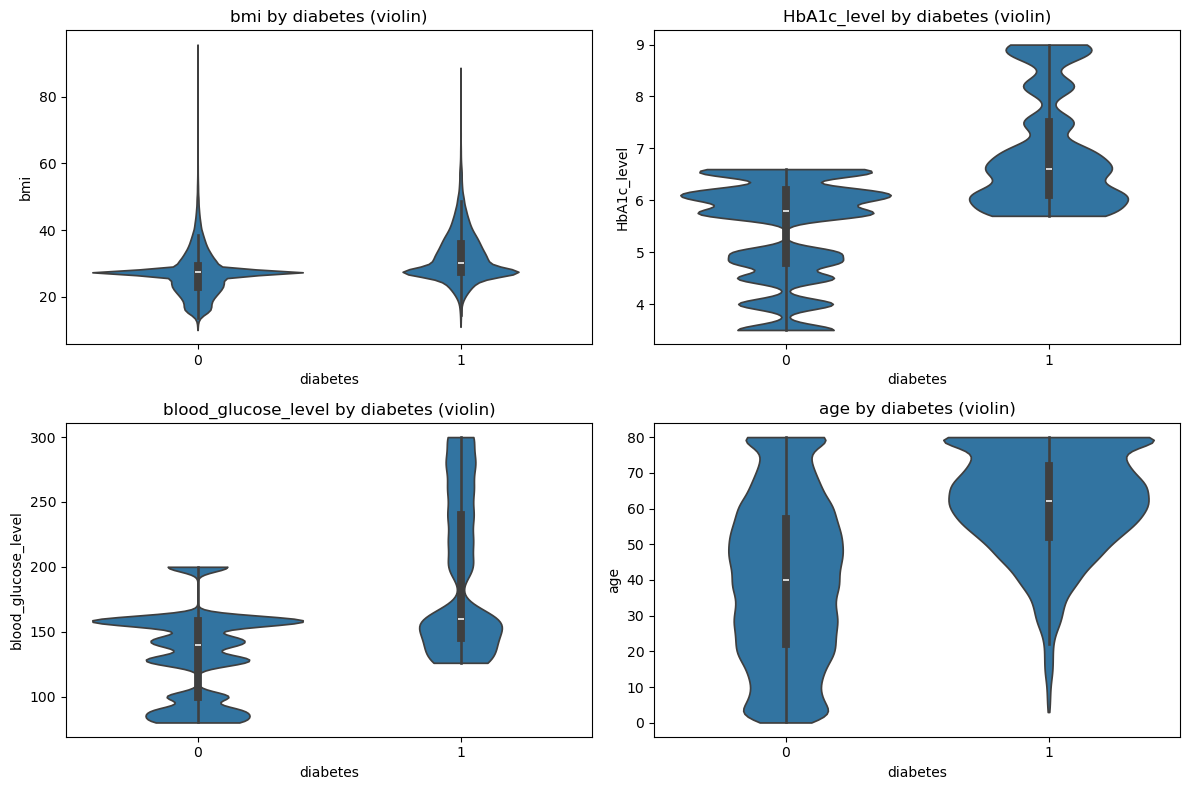

In [13]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(df_quantitative_columns, 1):
    plt.subplot(2, 2, i)
    sns.violinplot(x="diabetes", y=col, data=diab_clean, inner="box", cut=0)
    plt.title(f"{col} by diabetes (violin)")
plt.tight_layout()
plt.show()

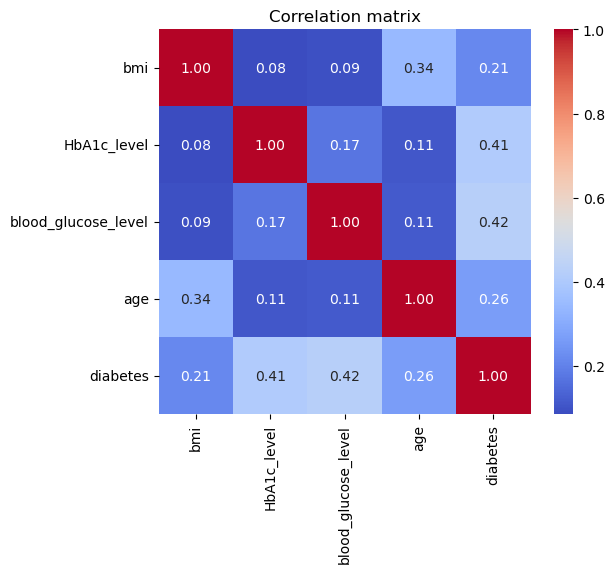

In [14]:
plt.figure(figsize=(6, 5))
corr = df_quantitative.join(diab_clean["diabetes"]).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix")
plt.show()

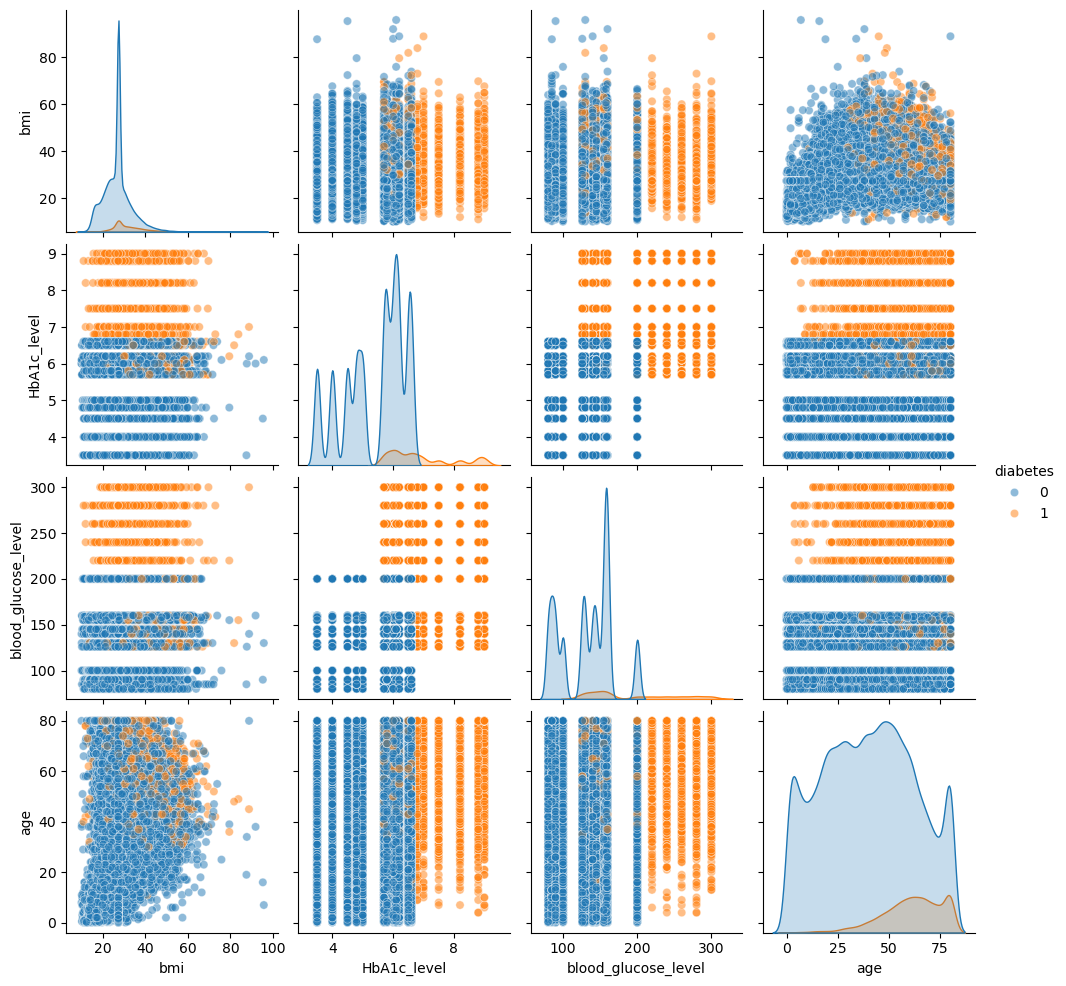

In [15]:
sns.pairplot(
    diab_clean,
    vars=df_quantitative_columns,
    hue="diabetes",
    diag_kind="kde",
    plot_kws={"alpha": 0.5},
    height=2.5,
)
plt.show()

In [16]:
continuous_cols = ["HbA1c_level", "age", "bmi", "blood_glucose_level"]

for col in continuous_cols:
    group1 = diab_clean[diab_clean["diabetes"] == 1][col]
    group0 = diab_clean[diab_clean["diabetes"] == 0][col]
    t_stat, p_val = ttest_ind(group1, group0, equal_var=False)

    mean1 = group1.mean()
    mean0 = group0.mean()

    print(f"--- T-test for '{col}' ---")
    print(f"Mean (Diabetic):     {mean1:.2f}")
    print(f"Mean (Non-Diabetic): {mean0:.2f}")
    print(f"T-statistic:         {t_stat:.3f}")
    print(f"P-value:             {p_val:.3f}")
    print(
        "Conclusion:          ",
        "Significant difference" if p_val < 0.05 else "No significant difference",
    )
    print()

categorical_cols = ["smoking_history", "hypertension", "gender", "heart_disease"]

for col in categorical_cols:
    contingency_table = pd.crosstab(diab_clean[col], diab_clean["diabetes"])
    chi2_stat, p_val_chi2, dof, expected = chi2_contingency(contingency_table)

    print(f"--- Chi-squared Test for '{col}' ---")
    print(f"Chi-squared statistic: {chi2_stat:.3f}")
    print(f"P-value:               {p_val_chi2:.3f}")
    print(
        "Conclusion:            ",
        "Association exists" if p_val_chi2 < 0.05 else "No association",
    )
    print()

--- T-test for 'HbA1c_level' ---
Mean (Diabetic):     6.93
Mean (Non-Diabetic): 5.40
T-statistic:         126.685
P-value:             0.000
Conclusion:           Significant difference

--- T-test for 'age' ---
Mean (Diabetic):     60.93
Mean (Non-Diabetic): 39.94
T-statistic:         119.991
P-value:             0.000
Conclusion:           Significant difference

--- T-test for 'bmi' ---
Mean (Diabetic):     32.00
Mean (Non-Diabetic): 26.87
T-statistic:         60.326
P-value:             0.000
Conclusion:           Significant difference

--- T-test for 'blood_glucose_level' ---
Mean (Diabetic):     194.03
Mean (Non-Diabetic): 132.82
T-statistic:         94.599
P-value:             0.000
Conclusion:           Significant difference

--- Chi-squared Test for 'smoking_history' ---
Chi-squared statistic: 1728.319
P-value:               0.000
Conclusion:             Association exists

--- Chi-squared Test for 'hypertension' ---
Chi-squared statistic: 3680.033
P-value:               0.0

# Model Implementation And Analysis 

In [17]:
class ModelAnalysis:
    def __init__(self, models):
        self.models = models

    def model_analysis_summary(self):
        models_name = []
        pre_macro = []
        rec_macro = []
        f1_macro = []
        pre_weighted = []
        rec_weighted = []
        f1_weighted = []

        for model in self.models:
            models_name.append(model.name)
            report = model.report

            pre_macro.append(report["precision"]["macro avg"])
            rec_macro.append(report["recall"]["macro avg"])
            f1_macro.append(report["f1-score"]["macro avg"])
            pre_weighted.append(report["precision"]["weighted avg"])
            rec_weighted.append(report["recall"]["weighted avg"])
            f1_weighted.append(report["f1-score"]["weighted avg"])

        self.models_report_data = {
            "Model": models_name,
            "Precision (Macro)": pre_macro,
            "Recall (Macro)": rec_macro,
            "F1-Score (Macro)": f1_macro,
            "Precision (Weighted)": pre_weighted,
            "Recall (Weighted)": rec_weighted,
            "F1-Score (Weighted)": f1_weighted,
        }

        self.models_report_df = pd.DataFrame(self.models_report_data)
        display(self.models_report_df.round(2))

    def overall_metrics_plot(self):
        df_print = self.models_report_df.copy(deep=True)
        df_print.set_index("Model", inplace=True)
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        df_print[
            ["Precision (Weighted)", "Recall (Weighted)", "F1-Score (Weighted)"]
        ].plot(kind="barh", ax=axes[0], colormap="Pastel2")
        axes[0].set_title("Model Performance (Weighted Metrics)")
        axes[0].set_xlabel("Score")
        axes[0].set_xlim(0, 1.05)
        axes[0].invert_yaxis()

        df_print[["Precision (Macro)", "Recall (Macro)", "F1-Score (Macro)"]].plot(
            kind="barh", ax=axes[1], colormap="Pastel1"
        )
        axes[1].set_title("Model Performance (Macro Metrics)")
        axes[1].set_xlabel("Score")
        axes[1].set_xlim(0, 1.05)
        axes[1].invert_yaxis()

        plt.tight_layout()
        plt.show()

    def plotting_macro_and_weighted_avgs(self):
        metrics = ["Precision", "Recall", "F1-Score"]
        fig, axes = plt.subplots(1, 3, figsize=(20, 8))
        for idx, metric in enumerate(metrics):
            df_plot = self.models_report_df.set_index("Model")[
                [f"{metric} (Macro)", f"{metric} (Weighted)"]
            ]
            df_plot.plot(kind="barh", ax=axes[idx], colormap="Set2")
            axes[idx].set_title(f"{metric} - Macro vs Weighted")
            axes[idx].set_xlabel("Score")
            axes[idx].invert_yaxis()
        plt.tight_layout()
        plt.show()


class Model:
    def __init__(self, name, x_train=None, x_test=None, y_train=None, y_test=None):
        self.name = name
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def report_model_performance(self):
        self.accuracy = accuracy_score(self.y_test, self.y_model_predict)
        print(f"{self.name} Accuracy: {self.accuracy:.2f}")
        self.report = pd.DataFrame(
            classification_report(
                self.y_test,
                self.y_model_predict,
                target_names=["No Diabetes", "Diabetes"],
                output_dict=True,
            )
        ).T
        print(self.report.round(2))
        self.confusion_matrix()

    def confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.y_model_predict)
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["No Diabetes", "Diabetes"],
            yticklabels=["No Diabetes", "Diabetes"],
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix for {self.name}")
        plt.show()

    def roc_curve(self):
        fpr, tpr, _ = roc_curve(self.y_test, self.y_prob)
        roc_auc = auc(fpr, tpr)
        RocCurveDisplay(
            fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=self.name
        ).plot()
        plt.title("ROC Curve")
        plt.show()

    def precision_recall_curve(self):
        precision, recall, _ = precision_recall_curve(self.y_test, self.y_prob)
        avg_prec = average_precision_score(self.y_test, self.y_prob)
        PrecisionRecallDisplay(
            precision=precision, recall=recall, average_precision=avg_prec
        ).plot()
        plt.show()

    def test_train_split(self, features, labels, testSize):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            features, labels, test_size=0.2
        )

    def predict(self, func, val=None):
        if val is None:
            val = self.x_test
        self.y_model_predict = func(val)

    def predict_prob(self, func, val=None):
        if val is None:
            val = self.x_test
        self.y_prob = func(val)[:, 1]

## Model Implementations with different feature Sets

Below is the list of models implemented and its efficiency is plotted. For each models different set of features are passed.

### Generalized Linear Model

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               diabetes   No. Observations:                76916
Model:                            GLM   Df Residuals:                    76908
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23329.
Date:                Mon, 23 Jun 2025   Deviance:                       46658.
Time:                        19:05:06   Pearson chi2:                 2.08e+05
No. Iterations:                     6   Pseudo R-squ. (CS):          -0.008115
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
HbA1c_level            -0.1708      0.009    -18.664      0.000      -0.189      -0.153
blood_glucose_level     0.0101      0.000     36.111      0.000       0.010       0.011
age                     0.0178      0.001     29.026      0.000       0.017       0.019
bmi                    -0.1208      0.002    -56.551      0.000      -0.125      -0.117
smoking_history_num     0.0003      0.008      0.037      0.971      -0.015       0.015
heart_disease           0.9532      0.045     21.022      0.000       0.864       1.042
hypertension            1.2632      0.036     35.084      0.000       1.193       1.334
gender_num             -0.8315      0.024    -34.138      0.000      -0.879      -0.784
=======================================================================================
"""

Generalized Linear Model Accuracy: 0.91
              precision  recall  f1-score   support
No Diabetes        0.92    0.99      0.95  17562.00
Diabetes           0.46    0.07      0.13   1668.00
accuracy           0.91    0.91      0.91      0.91
macro avg          0.69    0.53      0.54  19230.00
weighted avg       0.88    0.91      0.88  19230.00


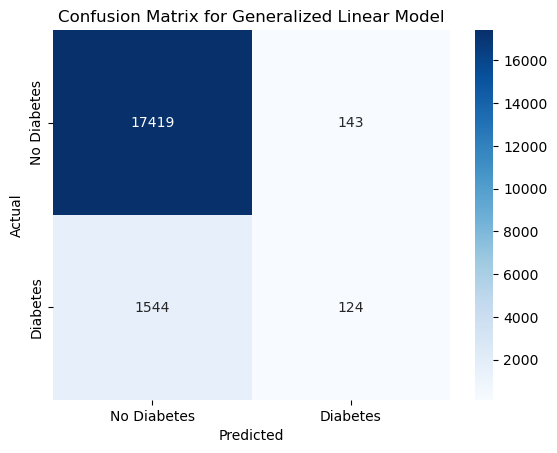

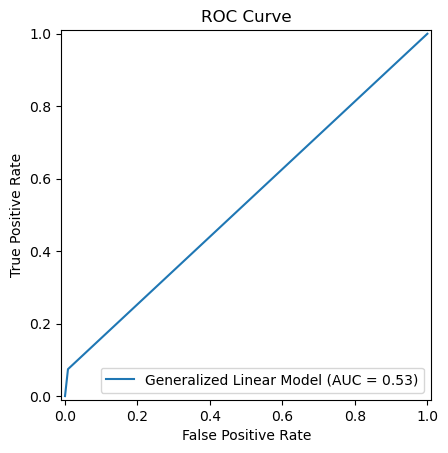

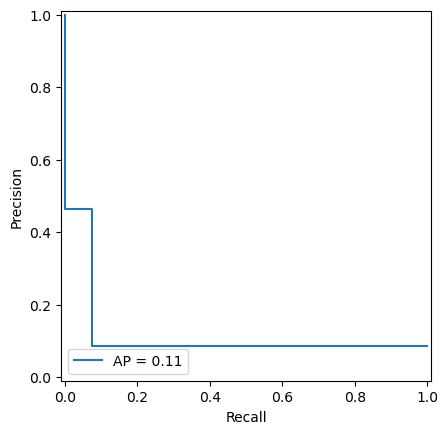

In [18]:
np.random.seed(SEED)

glm = Model("Generalized Linear Model")

glm.test_train_split(
    features=diab_clean[
        [
            "HbA1c_level",
            "blood_glucose_level",
            "age",
            "bmi",
            "smoking_history_num",
            "heart_disease",
            "hypertension",
            "gender_num",
        ]
    ],
    labels=diab_clean["diabetes"],
    testSize=0.2,
)

fit_response = sm.GLM(glm.y_train, glm.x_train, family=sm.families.Binomial()).fit()
display(fit_response.summary())
glm.predict(fit_response.predict)
glm.y_model_predict = glm.y_model_predict > 0.5
glm.y_prob = glm.y_model_predict
glm.report_model_performance()
glm.roc_curve()
glm.precision_recall_curve()

### Logistic Regression

Logistic Regression Accuracy: 0.96
              precision  recall  f1-score   support
No Diabetes        0.97    0.99      0.98  17562.00
Diabetes           0.87    0.63      0.73   1668.00
accuracy           0.96    0.96      0.96      0.96
macro avg          0.92    0.81      0.85  19230.00
weighted avg       0.96    0.96      0.96  19230.00


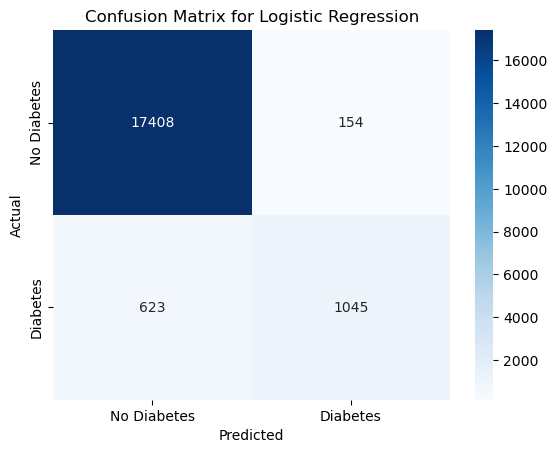

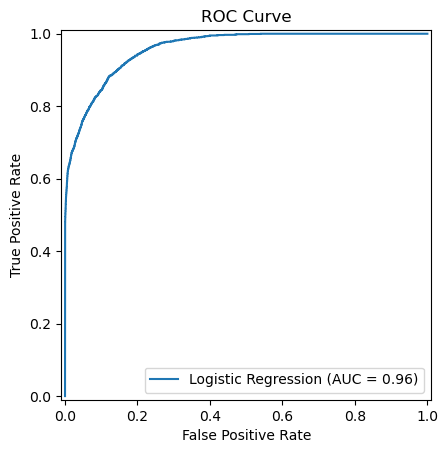

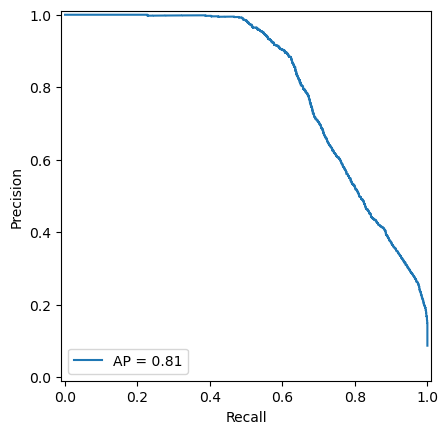

In [19]:
np.random.seed(SEED)

lr = Model("Logistic Regression")

lr.test_train_split(
    features=diab_clean[
        [
            "HbA1c_level",
            "blood_glucose_level",
            "age",
            "bmi",
        ]
    ],
    labels=diab_clean["diabetes"],
    testSize=0.2,
)

lr_model = LogisticRegression()
lr_model.fit(lr.x_train, lr.y_train)
lr.predict(lr_model.predict)
lr.predict_prob(lr_model.predict_proba)
lr.report_model_performance()
lr.roc_curve()
lr.precision_recall_curve()

### KMeans Clustering

KMeans Clustering Accuracy: 0.50
              precision  recall  f1-score  support
No Diabetes        0.99    0.45      0.62  17562.0
Diabetes           0.14    0.97      0.25   1668.0
accuracy           0.50    0.50      0.50      0.5
macro avg          0.57    0.71      0.44  19230.0
weighted avg       0.92    0.50      0.59  19230.0


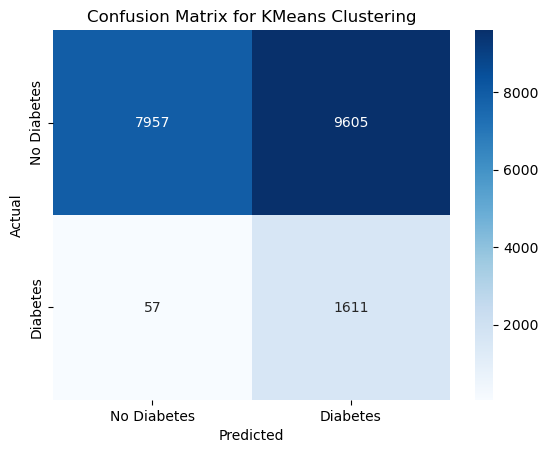

In [20]:
np.random.seed(SEED)

km = Model("KMeans Clustering")

km.test_train_split(
    features=diab_clean[["age", "bmi", "blood_glucose_level"]],
    labels=diab_clean["diabetes"],
    testSize=0.2,
)

scaler = StandardScaler()
km_model = KMeans(n_clusters=2)
km_model.fit(scaler.fit_transform(km.x_train))

km.predict(km_model.predict, val=scaler.transform(km.x_test))
km.report_model_performance()

### K-Nearest Neighbors

K-Nearest Neighbors Accuracy: 0.97
              precision  recall  f1-score   support
No Diabetes        0.97    1.00      0.98  17562.00
Diabetes           1.00    0.68      0.81   1668.00
accuracy           0.97    0.97      0.97      0.97
macro avg          0.99    0.84      0.90  19230.00
weighted avg       0.97    0.97      0.97  19230.00


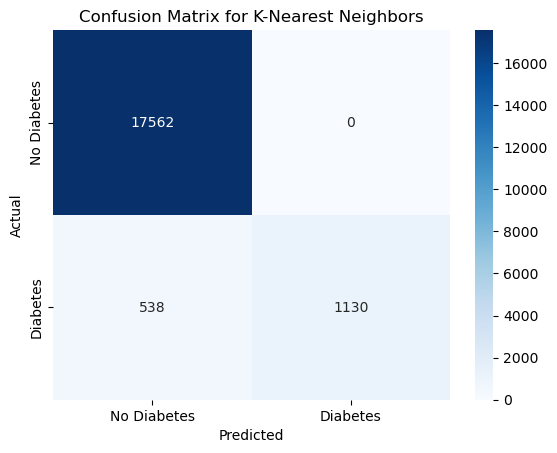

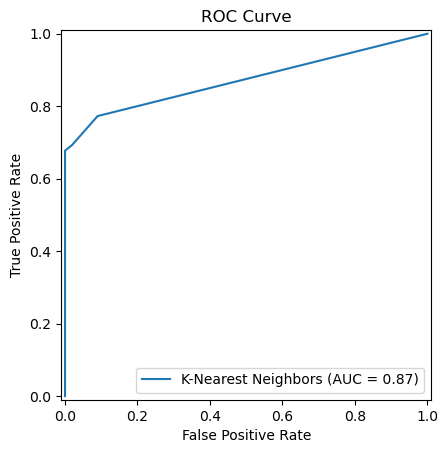

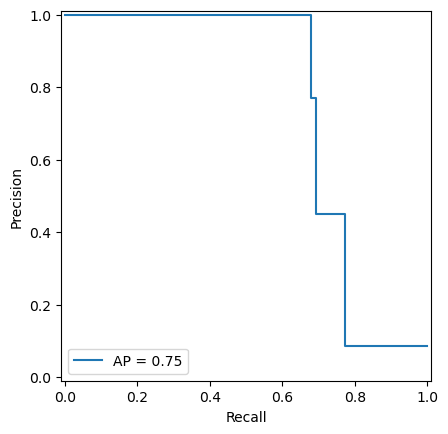

In [21]:
np.random.seed(SEED)

knn = Model("K-Nearest Neighbors")
knn.test_train_split(
    features=diab_clean[["HbA1c_level", "blood_glucose_level"]],
    labels=diab_clean["diabetes"],
    testSize=0.2,
)

knn_model = KNeighborsClassifier()
knn_model.fit(knn.x_train, knn.y_train)
knn.predict(knn_model.predict)
knn.predict_prob(knn_model.predict_proba)
knn.report_model_performance()
knn.roc_curve()
knn.precision_recall_curve()

### Decision Tree Classifier

Decision Tree Classifier Accuracy: 0.87
              precision  recall  f1-score   support
No Diabetes        0.98    0.88      0.93  17562.00
Diabetes           0.38    0.80      0.52   1668.00
accuracy           0.87    0.87      0.87      0.87
macro avg          0.68    0.84      0.72  19230.00
weighted avg       0.93    0.87      0.89  19230.00


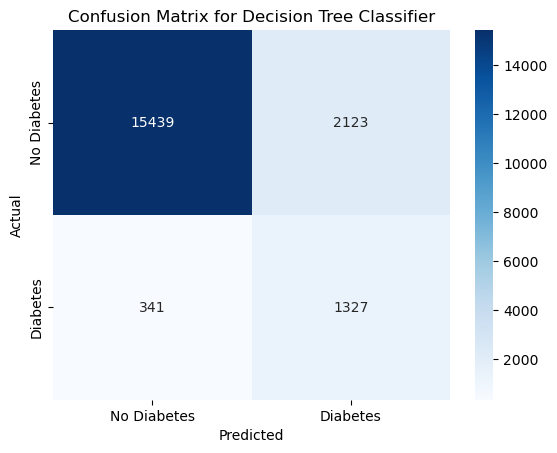

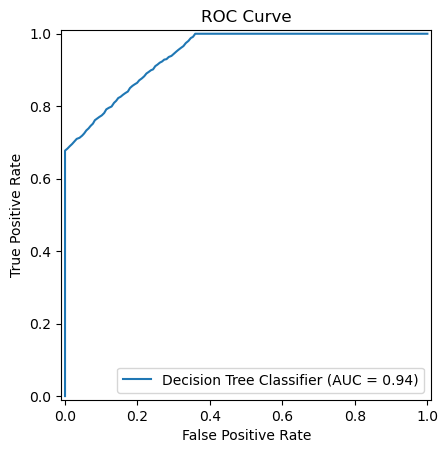

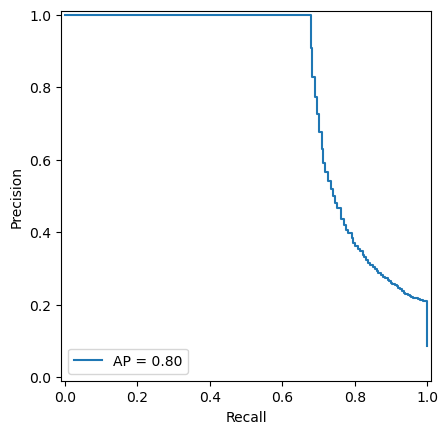

In [22]:
np.random.seed(SEED)

dtc = Model("Decision Tree Classifier")
dtc.test_train_split(
    features=diab_clean[["HbA1c_level", "blood_glucose_level"]],
    labels=diab_clean["diabetes"],
    testSize=0.2,
)

dtc_model = tree.DecisionTreeClassifier(class_weight="balanced")
dtc_model.fit(dtc.x_train, dtc.y_train)
dtc.predict(dtc_model.predict)
dtc.predict_prob(dtc_model.predict_proba)
dtc.report_model_performance()
dtc.roc_curve()
dtc.precision_recall_curve()

### Decision Tree Classifier weighted for diabetes recall

Decision Tree Classifier weighted for diabetes recall Accuracy: 0.67
              precision  recall  f1-score   support
No Diabetes        1.00    0.64      0.78  17555.00
Diabetes           0.21    1.00      0.35   1675.00
accuracy           0.67    0.67      0.67      0.67
macro avg          0.60    0.82      0.56  19230.00
weighted avg       0.93    0.67      0.74  19230.00


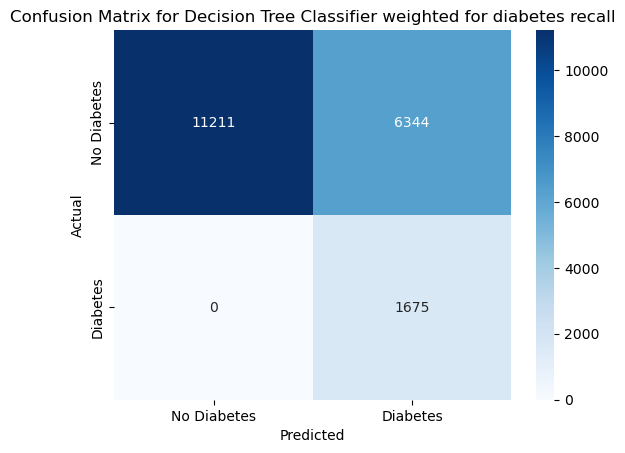

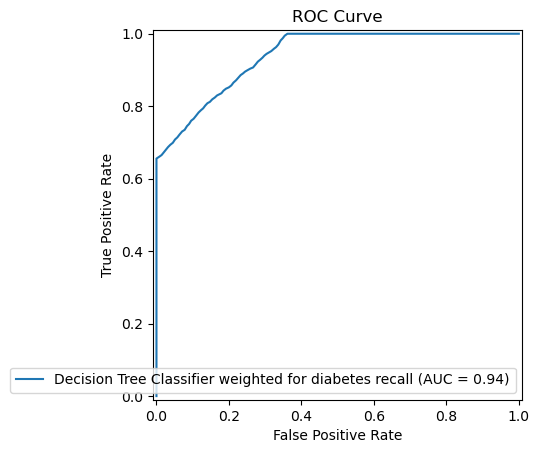

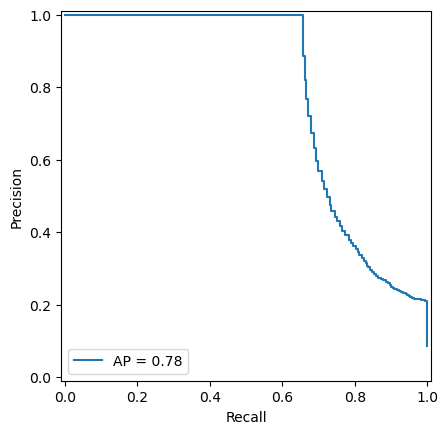

In [23]:
dtc_recall = Model("Decision Tree Classifier weighted for diabetes recall")
dtc_recall.test_train_split(
    features=diab_clean[["HbA1c_level", "blood_glucose_level"]],
    labels=diab_clean["diabetes"],
    testSize=0.2,
)

dtc_model_recall = tree.DecisionTreeClassifier(class_weight={0: 1, 1: 20})
dtc_model_recall.fit(dtc_recall.x_train, dtc_recall.y_train)
dtc_recall.predict(dtc_model_recall.predict)
dtc_recall.predict_prob(dtc_model_recall.predict_proba)
dtc_recall.report_model_performance()
dtc_recall.roc_curve()
dtc_recall.precision_recall_curve()

### Decision Tree Classifier - SMOTE Resampled

Decision Tree Classifier - SMOTE Resampled Accuracy: 0.88
              precision  recall  f1-score   support
No Diabetes        0.98    0.89      0.93  17562.00
Diabetes           0.39    0.79      0.53   1668.00
accuracy           0.88    0.88      0.88      0.88
macro avg          0.69    0.84      0.73  19230.00
weighted avg       0.93    0.88      0.89  19230.00


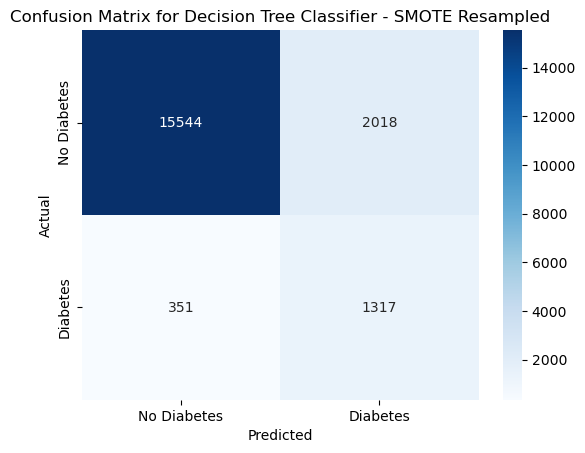

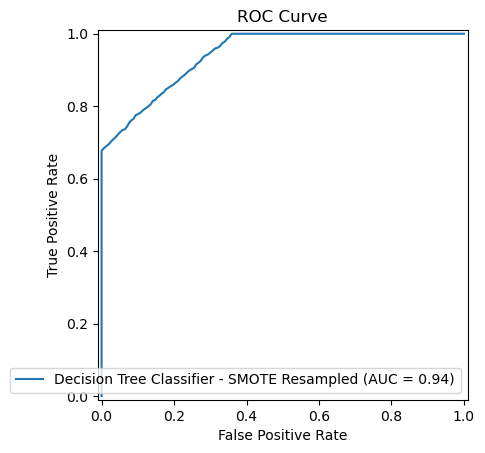

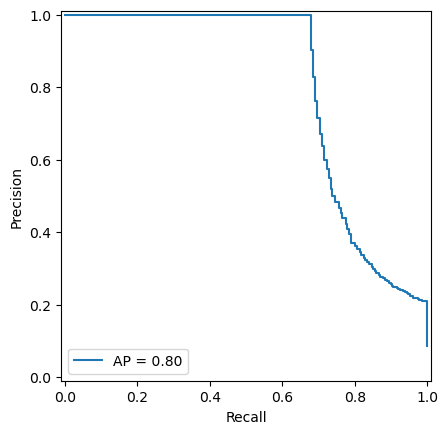

In [24]:
np.random.seed(SEED)

smote = Model("Decision Tree Classifier - SMOTE Resampled")
smote.test_train_split(
    features=diab_clean[["HbA1c_level", "blood_glucose_level"]],
    labels=diab_clean["diabetes"],
    testSize=0.2,
)

smote_model = SMOTE()
smote.x_train, smote.y_train = smote_model.fit_resample(smote.x_train, smote.y_train)

decision_tree_smote = tree.DecisionTreeClassifier()
decision_tree_smote.fit(smote.x_train, smote.y_train)

smote.predict(decision_tree_smote.predict)
smote.predict_prob(decision_tree_smote.predict_proba)
smote.report_model_performance()
smote.roc_curve()
smote.precision_recall_curve()

## Model Analysis

### Models Summary

For models ran with the different feature selection, this below summary provides the efficiency of the each model. 

,Model,Precision (Macro),Recall (Macro),F1-Score (Macro),Precision (Weighted),Recall (Weighted),F1-Score (Weighted)
0,Generalized Linear Model,0.69,0.53,0.54,0.88,0.91,0.88
1,Logistic Regression,0.92,0.81,0.85,0.96,0.96,0.96
2,KMeans Clustering,0.57,0.71,0.44,0.92,0.50,0.59
3,K-Nearest Neighbors,0.99,0.84,0.90,0.97,0.97,0.97
4,Decision Tree Classifier,0.68,0.84,0.72,0.93,0.87,0.89
5,Decision Tree Classifier weighted for diabetes...,0.60,0.82,0.56,0.93,0.67,0.74
6,Decision Tree Classifier - SMOTE Resampled,0.69,0.84,0.73,0.93,0.88,0.89


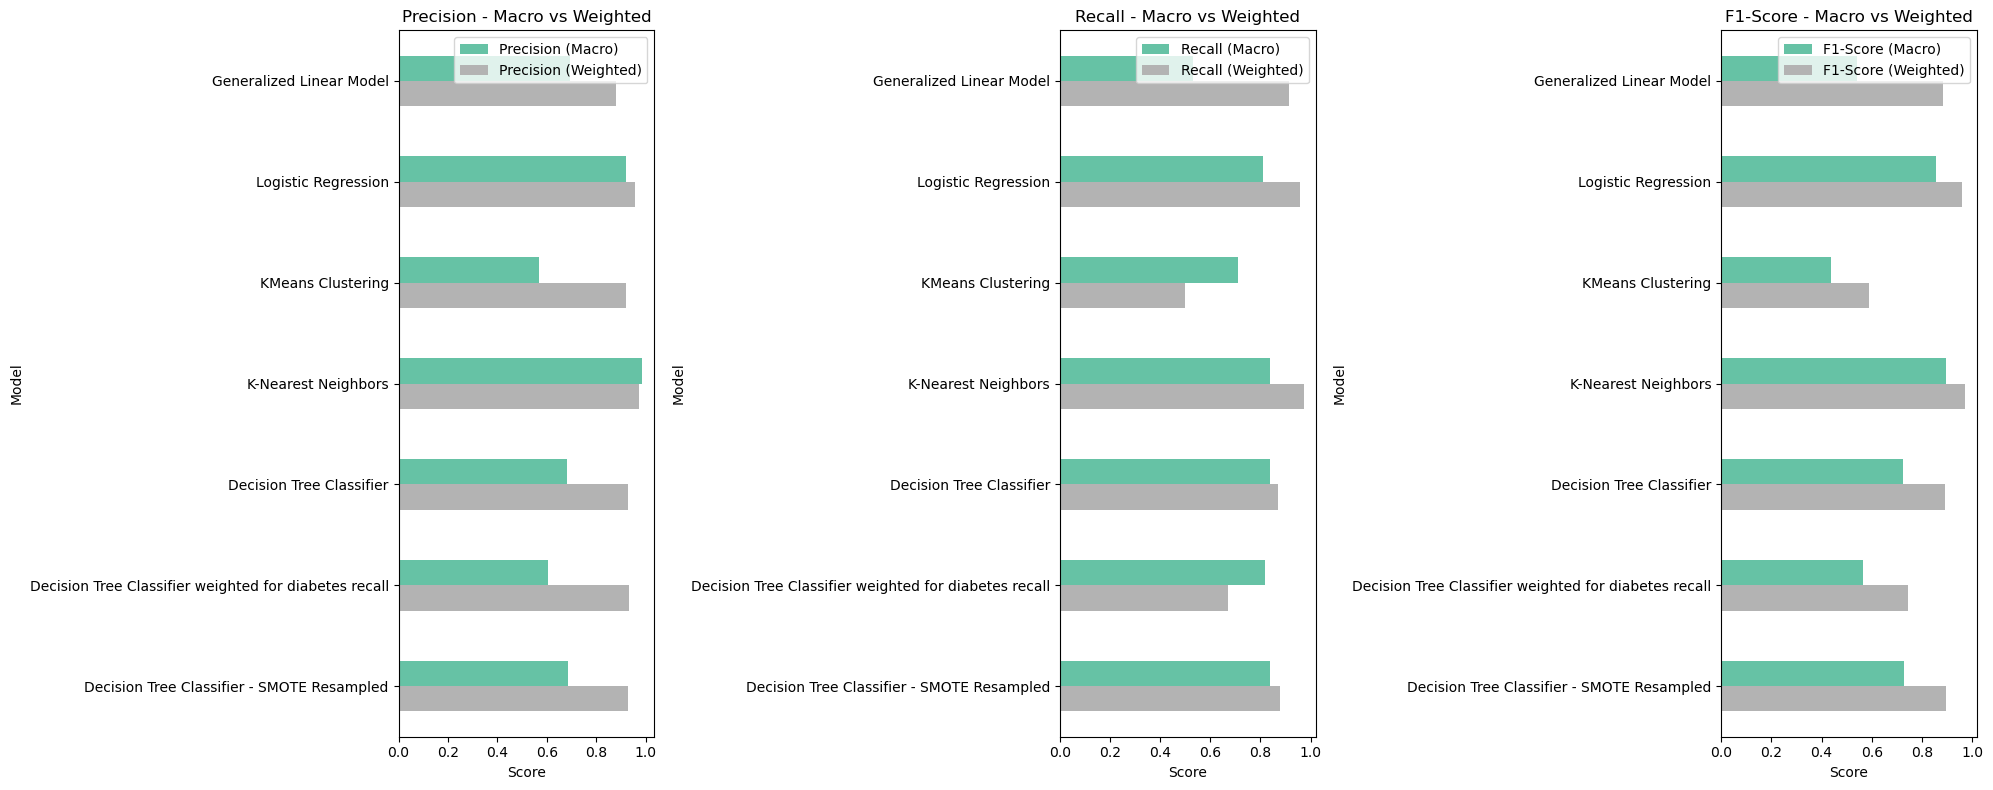

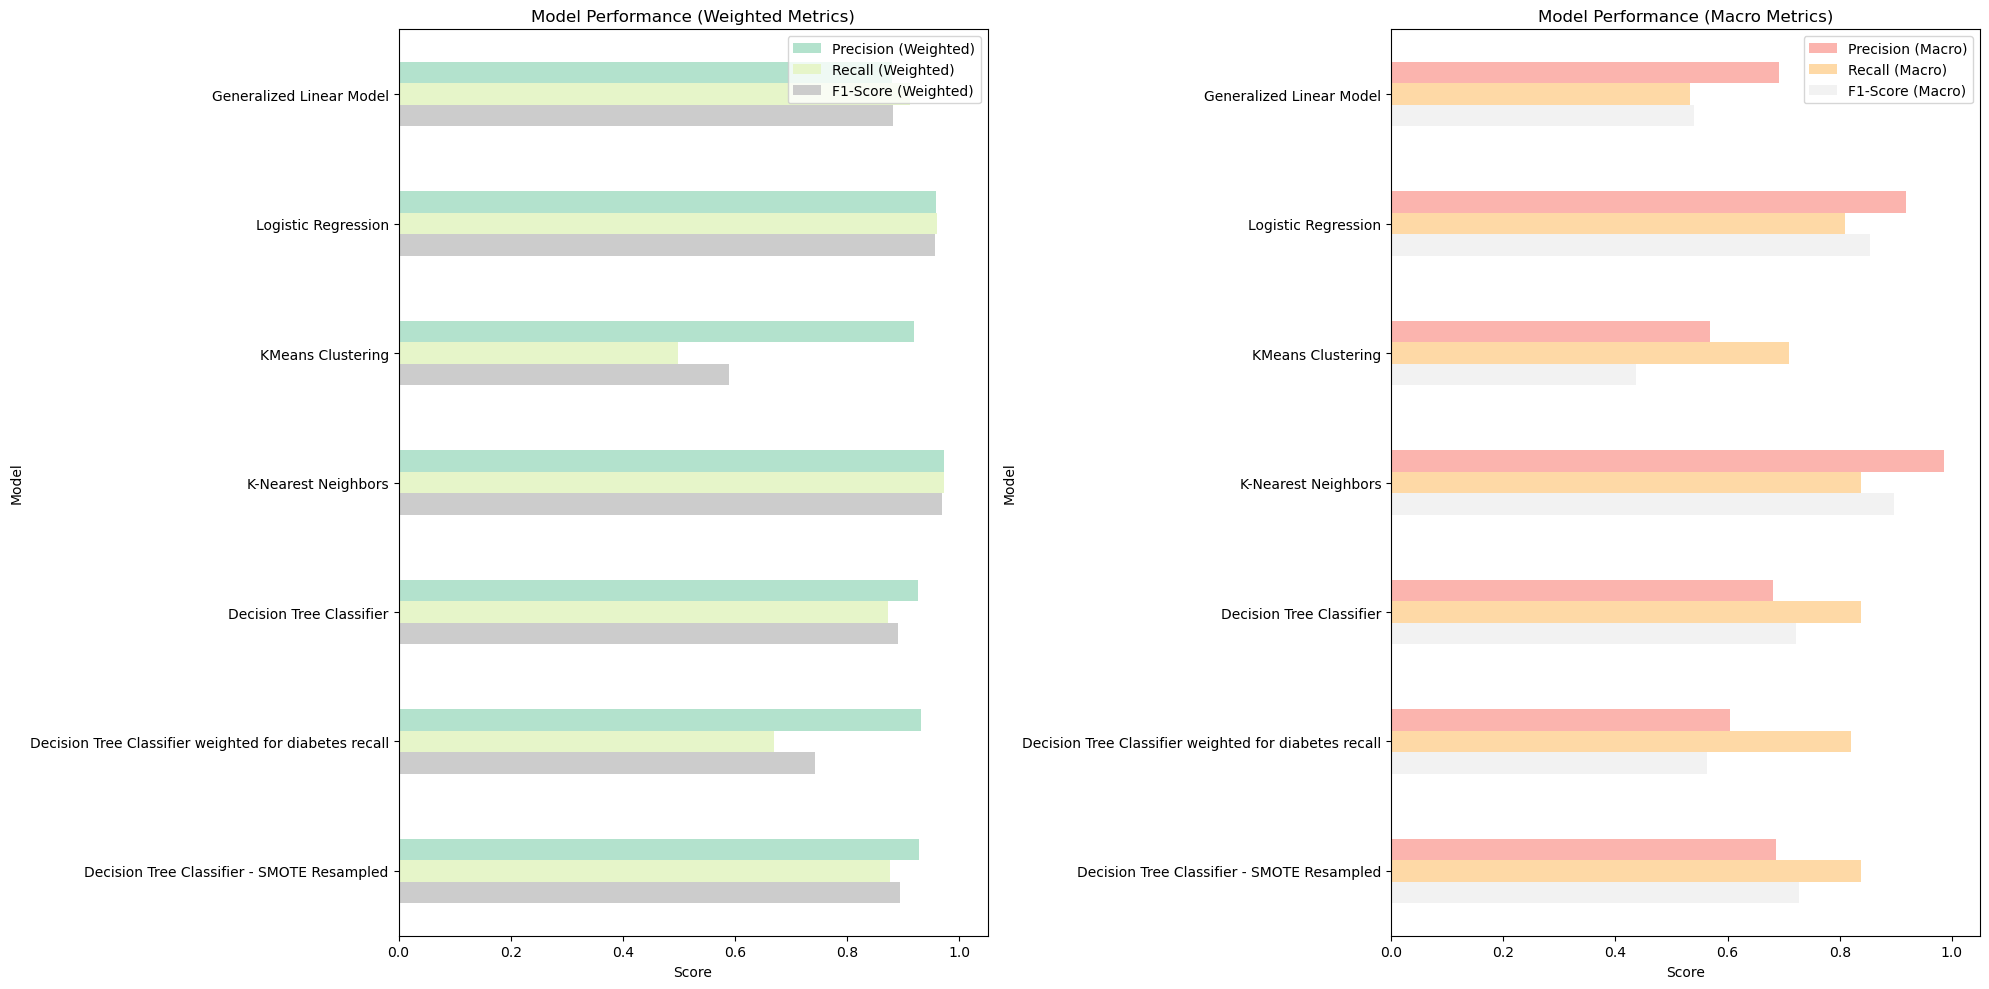

In [25]:
ma = ModelAnalysis([glm, lr, km, knn, dtc, dtc_recall, smote])
ma.model_analysis_summary()
ma.plotting_macro_and_weighted_avgs()
ma.overall_metrics_plot()

## Model Comparison with Formal Feature Selection

Above comparison provided us with the data and effiency of each model under different feature selection. Now we are formally selecting the top features to predict the diabetes. 

In [26]:
class FormalModelComparision:
    def __init__(self):
        self.diab_clean = diab_clean

    def select_top_features(
        self, top_n_anova=5, top_n_chi2=5, top_n_rf=5, include_rfe=5
    ):
        self.feature_selection_summary()
        top_features = self.feature_selection_summary_df
        anova_top = (
            top_features["Anova F"].sort_values(ascending=False).head(top_n_anova).index
        )
        chi2_top = (
            top_features["Chi2"].sort_values(ascending=False).head(top_n_chi2).index
        )
        rf_top = (
            top_features["RF Importance"]
            .sort_values(ascending=False)
            .head(top_n_rf)
            .index
        )
        rfe_top = (
            top_features["RFE Support"]
            .sort_values(ascending=False)
            .head(include_rfe)
            .index
        )

        self.top_features = set(anova_top).union(chi2_top).union(rf_top).union(rfe_top)
        display(top_features.loc[list(self.top_features)])

    def feature_selection_summary(self):
        diab_clean_updated = diab_clean.drop(
            columns=["smoking_history_num", "gender_num"]
        )
        features = diab_clean_updated.drop(columns=["diabetes"])
        labels = diab_clean_updated["diabetes"]
        features = pd.get_dummies(features)

        self.diab_clean_updated = diab_clean_updated
        self.features = features
        self.labels = labels

        # Normalize for chi2
        scaler = MinMaxScaler()
        features_scaled = pd.DataFrame(
            scaler.fit_transform(features), columns=features.columns
        )

        # Anova F-Test
        skb_f = SelectKBest(score_func=f_classif, k="all").fit(features, labels)
        anova_scores = pd.Series(skb_f.scores_, index=features.columns).sort_values(
            ascending=False
        )

        # Chi2
        skb_chi2 = SelectKBest(score_func=chi2, k="all").fit(features_scaled, labels)
        chi2_scores = pd.Series(skb_chi2.scores_, index=features.columns).sort_values(
            ascending=False
        )

        # Random Forest Importances
        rf = RandomForestClassifier(random_state=0)
        rf.fit(features, labels)
        rf_scores = pd.Series(
            rf.feature_importances_, index=features.columns
        ).sort_values(ascending=False)

        # RFE - Logistic Regression
        lr = LogisticRegression(max_iter=4000)
        rfe = RFE(estimator=lr, n_features_to_select=8)
        rfe.fit(features, labels)
        rfe_support = pd.Series(rfe.support_, index=features.columns)

        self.feature_selection_summary_df = pd.DataFrame(
            {
                "Anova F": anova_scores,
                "Chi2": chi2_scores,
                "RF Importance": rf_scores,
                "RFE Support": rfe_support.astype(bool),
            }
        )

In [27]:
fmc = FormalModelComparision()
fmc.select_top_features()
features = fmc.features[list(fmc.top_features)]
labels = fmc.labels

features = features.copy()
features["gender_Female"] = features["gender_Female"].map({True: 1, False: 0})
features["gender_Male"] = features["gender_Male"].map({True: 1, False: 0})
features["gender_Other"] = features["gender_Other"].map({True: 1, False: 0})


x_train, x_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

,Anova F,Chi2,RF Importance,RFE Support
age,7257.356029,1021.343155,0.104736,False
heart_disease,2885.951707,2687.582087,0.011628,True
gender_Male,138.177946,80.624462,0.002071,True
gender_Other,1.741926,1.741604,0.000001,True
gender_Female,137.298234,57.019068,0.002064,True
bmi,4656.545262,137.150901,0.125518,False
blood_glucose_level,21113.489195,2262.135136,0.324444,False
hypertension,3829.202325,3396.838356,0.015809,True
HbA1c_level,19021.654018,1636.148704,0.397501,True


### Generalized Linear Model

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               diabetes   No. Observations:                76916
Model:                            GLM   Df Residuals:                    76907
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8988.0
Date:                Mon, 23 Jun 2025   Deviance:                       17976.
Time:                        19:05:34   Pearson chi2:                 4.77e+04
No. Iterations:                    22   Pseudo R-squ. (CS):             0.3045
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
age                     0.0474      0.001     38.475      0.000       0.045       0.050
heart_disease           0.7465      0.067     11.102      0.000       0.615       0.878
gender_Male           -26.9863      0.321    -83.948      0.000     -27.616     -26.356
gender_Other          -46.6760   1.74e+04     -0.003      0.998   -3.41e+04     3.4e+04
gender_Female         -27.2817      0.323    -84.488      0.000     -27.915     -26.649
bmi                     0.0885      0.003     31.142      0.000       0.083       0.094
blood_glucose_level     0.0334      0.001     61.786      0.000       0.032       0.034
hypertension            0.7952      0.052     15.255      0.000       0.693       0.897
HbA1c_level             2.3237      0.040     58.476      0.000       2.246       2.402
=======================================================================================
"""

Generalized Linear Model Accuracy: 0.96
              precision  recall  f1-score   support
No Diabetes        0.97    0.99      0.98  17534.00
Diabetes           0.87    0.63      0.73   1696.00
accuracy           0.96    0.96      0.96      0.96
macro avg          0.92    0.81      0.86  19230.00
weighted avg       0.96    0.96      0.96  19230.00


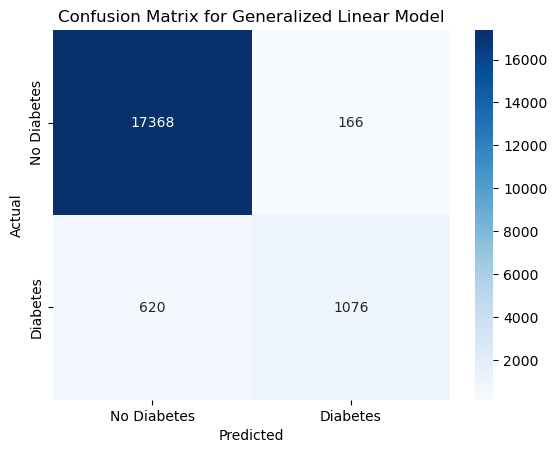

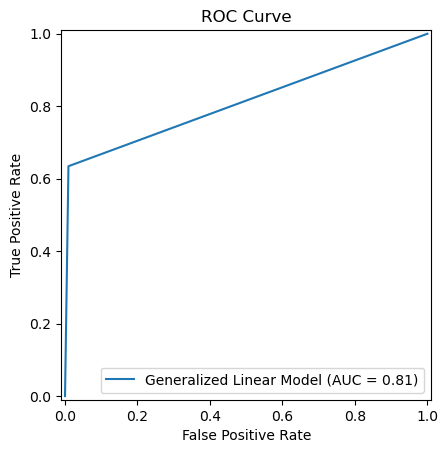

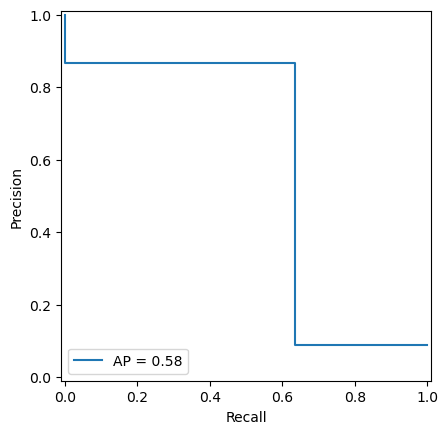

In [28]:
formal_glm = Model(
    "Generalized Linear Model",
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
)
fit_response = sm.GLM(
    formal_glm.y_train, formal_glm.x_train, family=sm.families.Binomial()
).fit()

display(fit_response.summary())
formal_glm.predict(fit_response.predict)
formal_glm.y_model_predict = formal_glm.y_model_predict > 0.5
formal_glm.y_prob = formal_glm.y_model_predict
formal_glm.report_model_performance()
formal_glm.roc_curve()
formal_glm.precision_recall_curve()

### Logistic Regression

Logistic Regression Accuracy: 0.96
              precision  recall  f1-score   support
No Diabetes        0.97    0.99      0.98  17534.00
Diabetes           0.87    0.63      0.73   1696.00
accuracy           0.96    0.96      0.96      0.96
macro avg          0.92    0.81      0.86  19230.00
weighted avg       0.96    0.96      0.96  19230.00


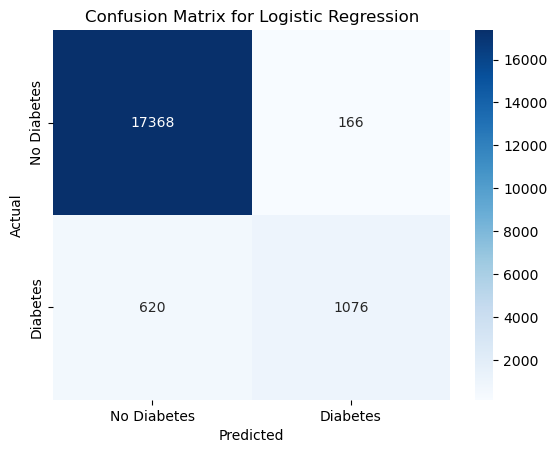

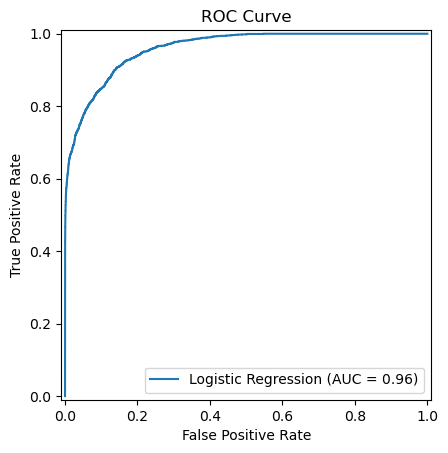

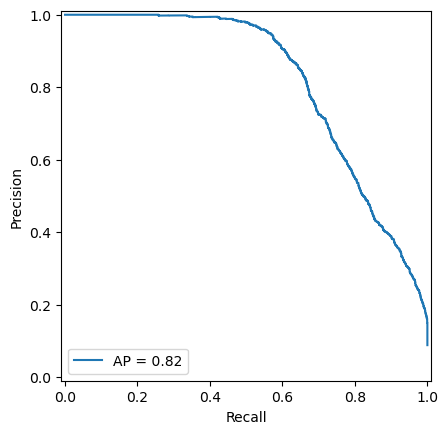

In [29]:
formal_logistic_regression = Model(
    "Logistic Regression",
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
)
lrModel = LogisticRegression(max_iter=4000)
lrModel.fit(formal_logistic_regression.x_train, formal_logistic_regression.y_train)

formal_logistic_regression.predict(lrModel.predict)
formal_logistic_regression.predict_prob(lrModel.predict_proba)
formal_logistic_regression.report_model_performance()
formal_logistic_regression.roc_curve()
formal_logistic_regression.precision_recall_curve()

### K-Nearest Neighbors


K Nearest Neighbors Accuracy: 0.95
              precision  recall  f1-score   support
No Diabetes        0.96    0.99      0.98  17534.00
Diabetes           0.88    0.55      0.68   1696.00
accuracy           0.95    0.95      0.95      0.95
macro avg          0.92    0.77      0.83  19230.00
weighted avg       0.95    0.95      0.95  19230.00


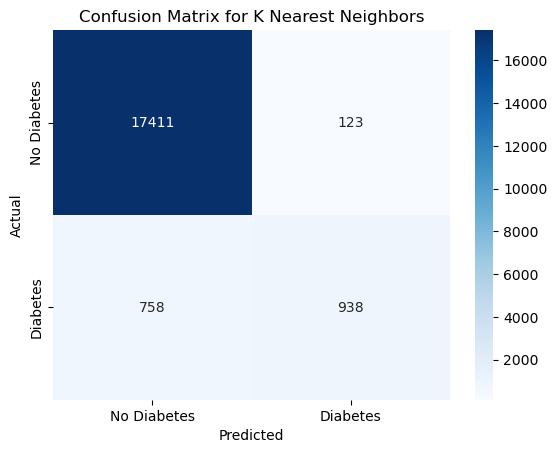

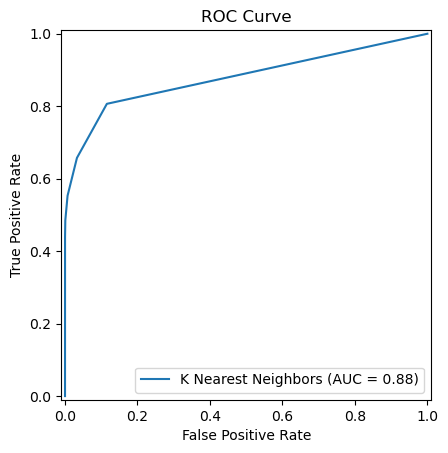

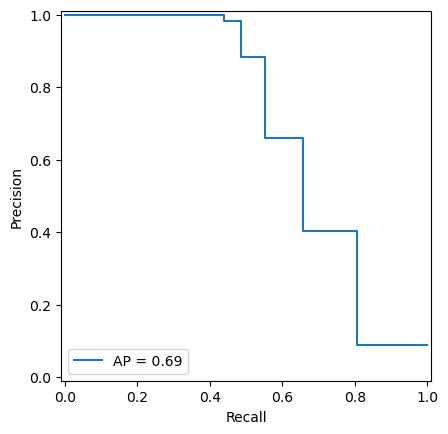

In [30]:
formal_knn = Model(
    "K Nearest Neighbors",
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
)
knModel = KNeighborsClassifier()
knModel.fit(formal_knn.x_train, formal_knn.y_train)
formal_knn.predict(knModel.predict)
formal_knn.predict_prob(knModel.predict_proba)
formal_knn.report_model_performance()
formal_knn.roc_curve()
formal_knn.precision_recall_curve()

### Decision Tree Classifier Balanced

Decision Tree Classifier Balanced Accuracy: 0.95
              precision  recall  f1-score   support
No Diabetes        0.97    0.97      0.97  17534.00
Diabetes           0.71    0.74      0.72   1696.00
accuracy           0.95    0.95      0.95      0.95
macro avg          0.84    0.85      0.85  19230.00
weighted avg       0.95    0.95      0.95  19230.00


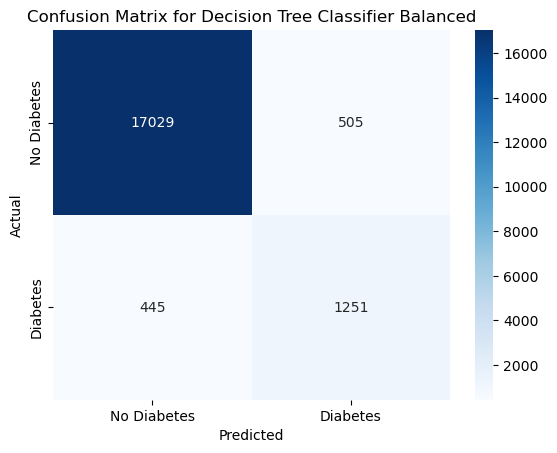

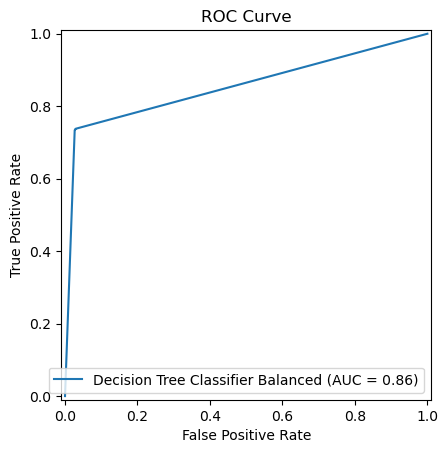

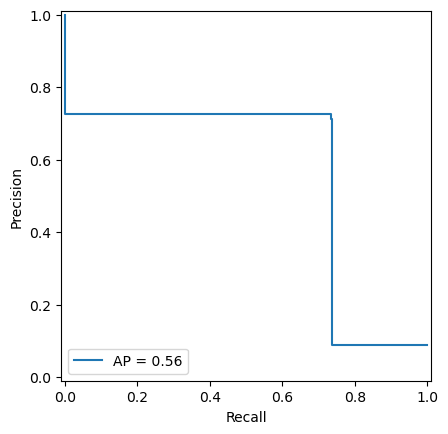

In [31]:
formal_dcc_balanced = Model(
    "Decision Tree Classifier Balanced",
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
)
dtc_model = tree.DecisionTreeClassifier(class_weight="balanced")
dtc_model.fit(formal_dcc_balanced.x_train, formal_dcc_balanced.y_train)
formal_dcc_balanced.predict(dtc_model.predict)
formal_dcc_balanced.predict_prob(dtc_model.predict_proba)
formal_dcc_balanced.report_model_performance()
formal_dcc_balanced.roc_curve()
formal_dcc_balanced.precision_recall_curve()

### Decision Tree Classifier weighted for diabetes recall

Decision Tree Classifier weighted for diabetes recall Accuracy: 0.95
              precision  recall  f1-score   support
No Diabetes        0.98    0.97      0.97  17534.00
Diabetes           0.73    0.74      0.74   1696.00
accuracy           0.95    0.95      0.95      0.95
macro avg          0.85    0.86      0.86  19230.00
weighted avg       0.95    0.95      0.95  19230.00


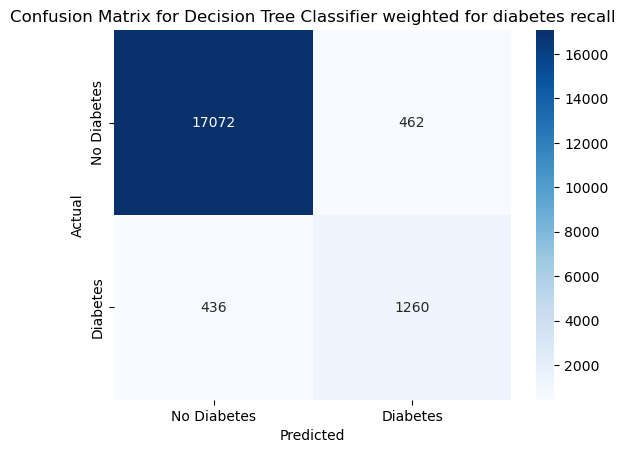

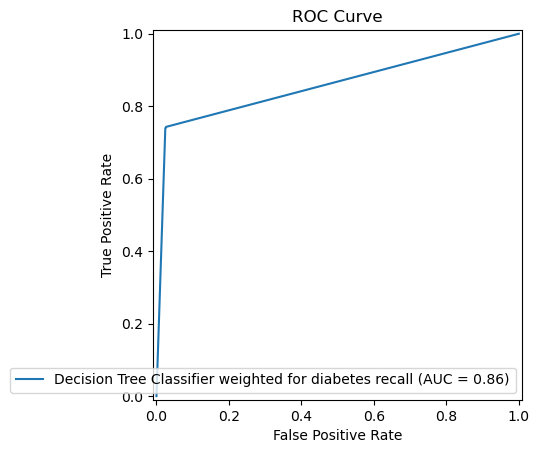

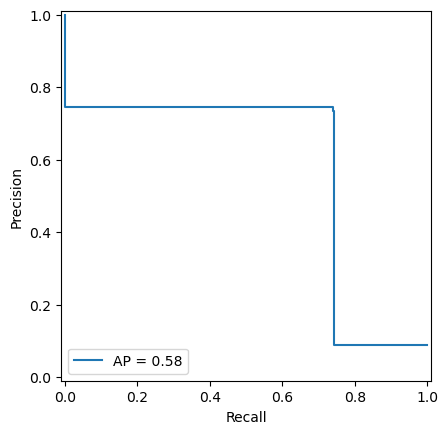

In [32]:
formal_dtc_recall = Model(
    "Decision Tree Classifier weighted for diabetes recall",
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
)

dtcModelRecall = tree.DecisionTreeClassifier(class_weight={0: 1, 1: 20})
dtcModelRecall.fit(formal_dtc_recall.x_train, formal_dtc_recall.y_train)
formal_dtc_recall.predict(dtcModelRecall.predict)
formal_dtc_recall.predict_prob(dtcModelRecall.predict_proba)
formal_dtc_recall.report_model_performance()
formal_dtc_recall.roc_curve()
formal_dtc_recall.precision_recall_curve()

### Decision Tree Classifier - SMOTE Resampled

Decision Tree Classifier - SMOTE Resampled Accuracy: 0.95
              precision  recall  f1-score   support
No Diabetes        0.97    0.97      0.97  17534.00
Diabetes           0.72    0.74      0.73   1696.00
accuracy           0.95    0.95      0.95      0.95
macro avg          0.85    0.85      0.85  19230.00
weighted avg       0.95    0.95      0.95  19230.00


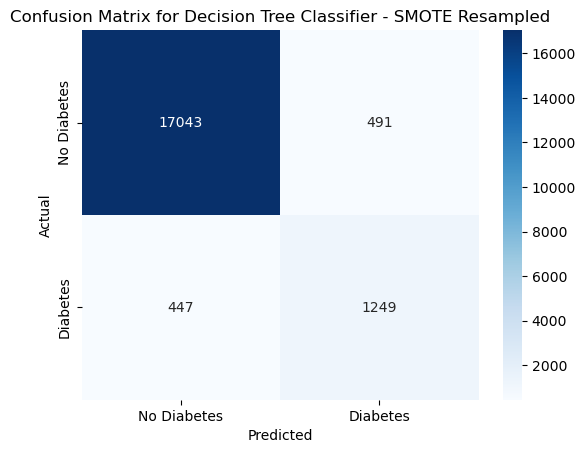

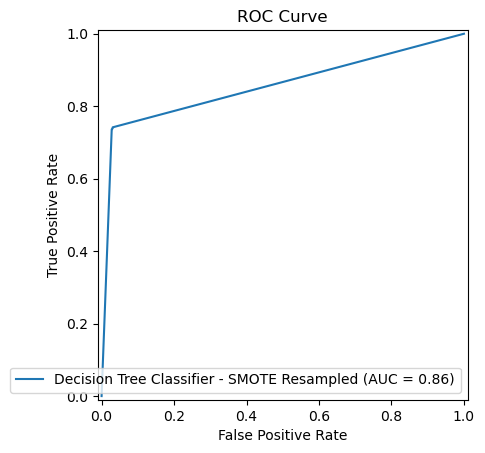

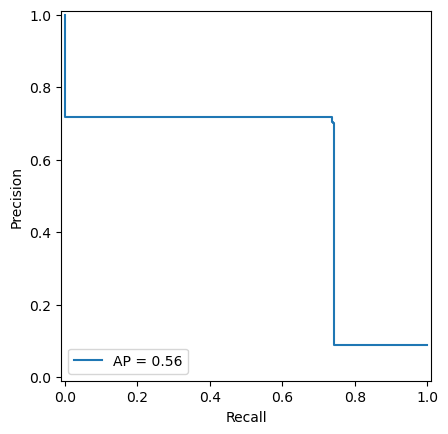

In [33]:
formal_smote = Model(
    "Decision Tree Classifier - SMOTE Resampled",
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
)
smote_model = SMOTE()
smote.x_train, smote.y_train = smote_model.fit_resample(
    formal_smote.x_train, formal_smote.y_train
)

decision_tree_smote = tree.DecisionTreeClassifier()
decision_tree_smote.fit(formal_smote.x_train, formal_smote.y_train)

formal_smote.predict(decision_tree_smote.predict)
formal_smote.predict_prob(decision_tree_smote.predict_proba)
formal_smote.report_model_performance()
formal_smote.roc_curve()
formal_smote.precision_recall_curve()

## Model Analysis



### Model Summary

By Comparing the overall analysis, results of models with the random feature selection vs formalized feature selection, later efficieny would have been increased and provide us with the more accurate response.

,Model,Precision (Macro),Recall (Macro),F1-Score (Macro),Precision (Weighted),Recall (Weighted),F1-Score (Weighted)
0,Generalized Linear Model,0.92,0.81,0.86,0.96,0.96,0.96
1,Logistic Regression,0.92,0.81,0.86,0.96,0.96,0.96
2,K Nearest Neighbors,0.92,0.77,0.83,0.95,0.95,0.95
3,Decision Tree Classifier Balanced,0.84,0.85,0.85,0.95,0.95,0.95
4,Decision Tree Classifier weighted for diabetes...,0.85,0.86,0.86,0.95,0.95,0.95
5,Decision Tree Classifier - SMOTE Resampled,0.85,0.85,0.85,0.95,0.95,0.95


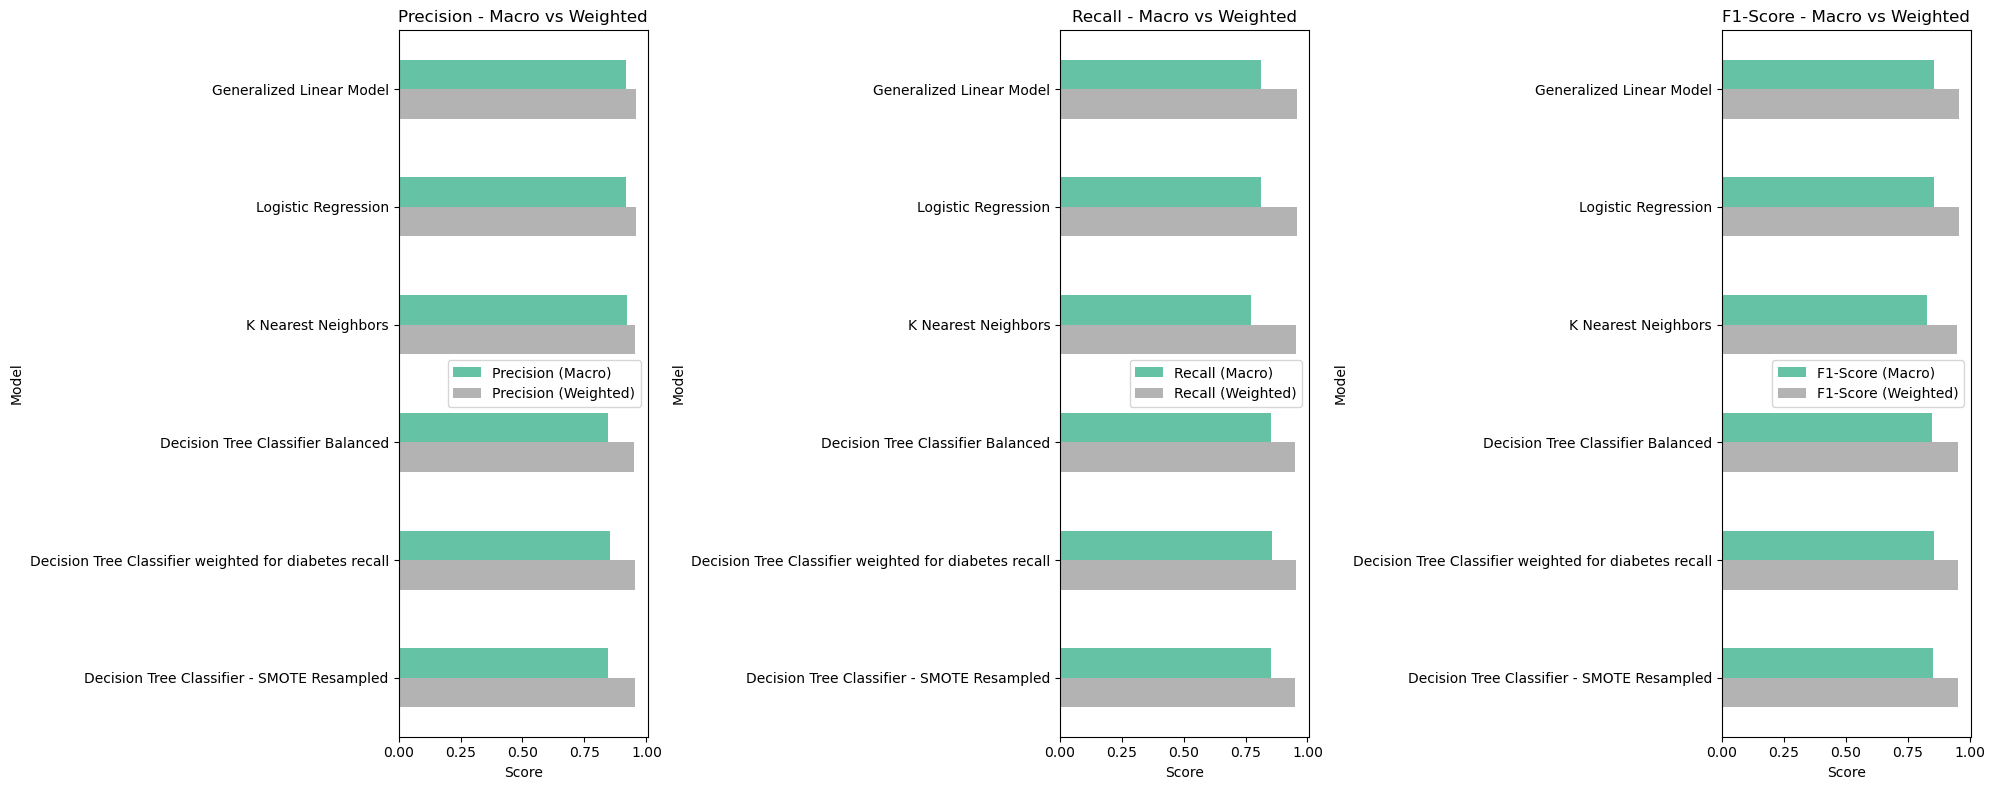

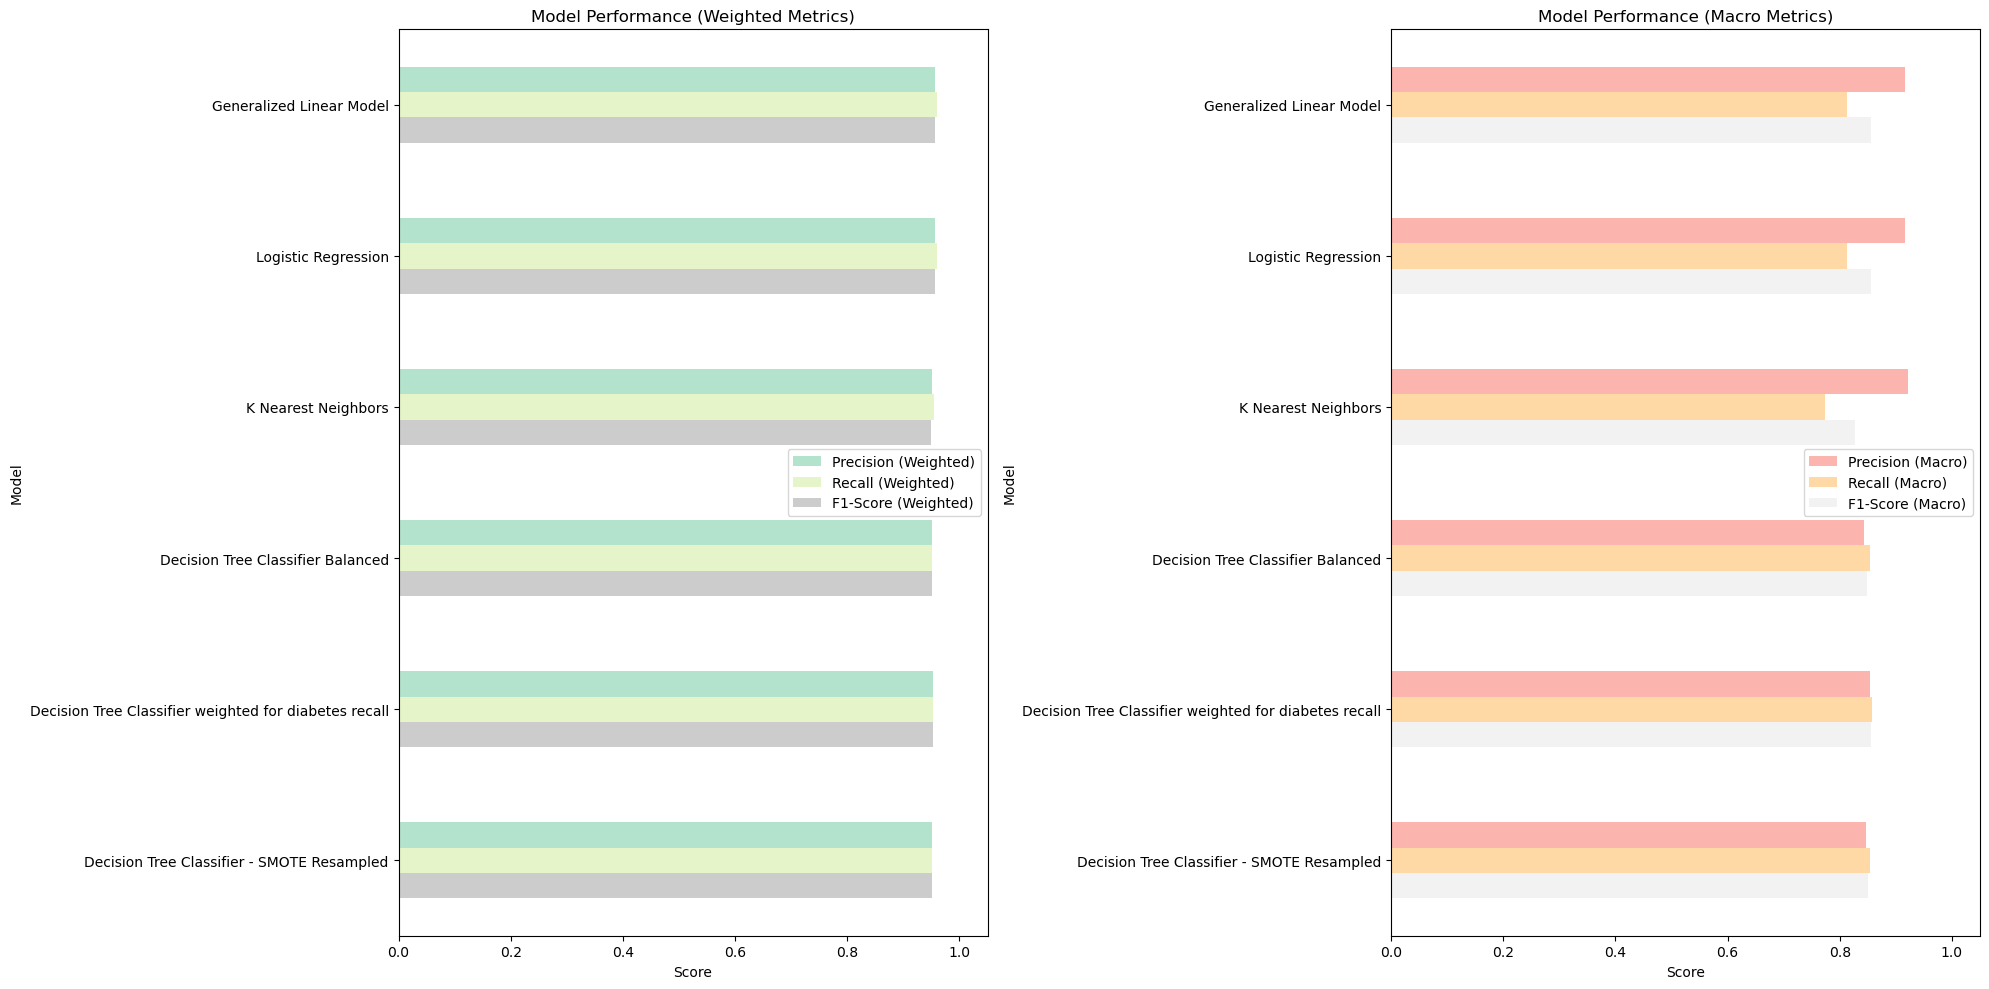

In [34]:
formal_ma = ModelAnalysis(
    [
        formal_glm,
        formal_logistic_regression,
        formal_knn,
        formal_dcc_balanced,
        formal_dtc_recall,
        formal_smote,
    ]
)
formal_ma.model_analysis_summary()
formal_ma.plotting_macro_and_weighted_avgs()
formal_ma.overall_metrics_plot()